In [1]:
import pandas as pd
import numpy as np
from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeClassifier
import RandomBinningFeatures as rbf
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
kdd = pd.read_csv("kddcup.data.corrected",sep=",",header=None, prefix='X')
kdd_test = pd.read_csv("corrected",sep=",",header=None,prefix="X")

In [3]:
kdd['X41'] = 2.* np.array(kdd['X41']=='normal.')
kdd['X41'] = kdd['X41'] - 1.
y_train = kdd['X41']

In [4]:
kdd_test['X41'] = 2.* np.array(kdd_test['X41']=='normal.')
kdd_test['X41'] = kdd_test['X41'] - 1.
y_test = kdd_test['X41']
kdd_test.head()

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X32,X33,X34,X35,X36,X37,X38,X39,X40,X41
0,0,udp,private,SF,105,146,0,0,0,0,...,254,1.0,0.01,0.00,0.0,0.0,0.0,0.0,0.0,1.0
1,0,udp,private,SF,105,146,0,0,0,0,...,254,1.0,0.01,0.00,0.0,0.0,0.0,0.0,0.0,1.0
2,0,udp,private,SF,105,146,0,0,0,0,...,254,1.0,0.01,0.00,0.0,0.0,0.0,0.0,0.0,1.0
3,0,udp,private,SF,105,146,0,0,0,0,...,254,1.0,0.01,0.00,0.0,0.0,0.0,0.0,0.0,-1.0
4,0,udp,private,SF,105,146,0,0,0,0,...,254,1.0,0.01,0.01,0.0,0.0,0.0,0.0,0.0,-1.0


In [5]:
kddtrain = kdd.drop(["X41"],axis=1)
kddtest = kdd_test.drop(["X41"],axis=1)

#### NO MISSING VALUES!!!

In [6]:
kdd.isnull().values.any()

False

In [7]:
kddtest.isnull().values.any()

False

### Preprocessing

In [8]:
kdd_str_col = kddtrain.select_dtypes(exclude = ['int64', 'float64']).columns

In [9]:
kdd_total = pd.concat([kddtrain,kddtest],axis=0)

In [10]:
kdd_total_dummy = pd.get_dummies(kdd_total[kdd_str_col])

In [11]:
kdd_total_dummy.head()

,X1_icmp,X1_tcp,X1_udp,X2_IRC,X2_X11,X2_Z39_50,X2_aol,X2_auth,X2_bgp,X2_courier,...,X3_REJ,X3_RSTO,X3_RSTOS0,X3_RSTR,X3_S0,X3_S1,X3_S2,X3_S3,X3_SF,X3_SH
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [12]:
kdd_dummy = pd.concat([kdd_total.drop(kdd_str_col, axis=1), kdd_total_dummy], axis=1)

In [13]:
kdd_dummy.head()

,X0,X4,X5,X6,X7,X8,X9,X10,X11,X12,...,X3_REJ,X3_RSTO,X3_RSTOS0,X3_RSTR,X3_S0,X3_S1,X3_S2,X3_S3,X3_SF,X3_SH
0,0,215,45076,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
1,0,162,4528,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
2,0,236,1228,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
3,0,233,2032,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
4,0,239,486,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0


In [14]:
X_train = kdd_dummy[:4898431]
X_test = kdd_dummy[4898431:]

## kernel approximation

In [15]:
def classification_err(y_test, y_pred):
    return (0.5 - np.dot(np.sign(y_test), y_pred)/len(y_test)/2)

In [16]:
import time
start_time = time.time()
rbfs = RBFSampler(gamma=0.0001,n_components=50,random_state=42)
Z = rbfs.fit(X_train)
train_features = Z.transform(X_train)
test_features = Z.transform(X_test)

clf = RidgeClassifier(alpha=10., solver='svd',random_state=42)
clf.fit(train_features, y_train) 
y_pred = clf.predict(test_features)
print("--- %s seconds ---" % (time.time() - start_time))

--- 29.099948406219482 seconds ---


In [17]:
error = classification_err(y_test, y_pred)
print("testing error:   %0.3f" % error)

testing error:   0.110


In [18]:
def plot_error_and_time(D,gamma=0.01,alpha=10.):
    times = []
    errs = [] 
    for d in D:
        start_time = time.time()
        rbfs = RBFSampler(gamma=gamma,n_components=d,random_state=42)
        Z = rbfs.fit(X_train)
        train_features = Z.transform(X_train)
        test_features = Z.transform(X_test)

        clf = RidgeClassifier(alpha=alpha, solver='svd')
        clf.fit(train_features, y_train) 
        y_pred = clf.predict(test_features)

        times.append(time.time() - start_time)
        errs.append(classification_err(y_test, y_pred)*100) 
    plt.figure(figsize=(12,6))
    plt.subplot(121)
    plt.plot(D, times)
    plt.xlabel("D")
    plt.ylabel("training and testing time(sec)")
    plt.subplot(122)
    plt.plot(D,errs)
    plt.xlabel("D")
    plt.ylabel("testing error rate(%)")

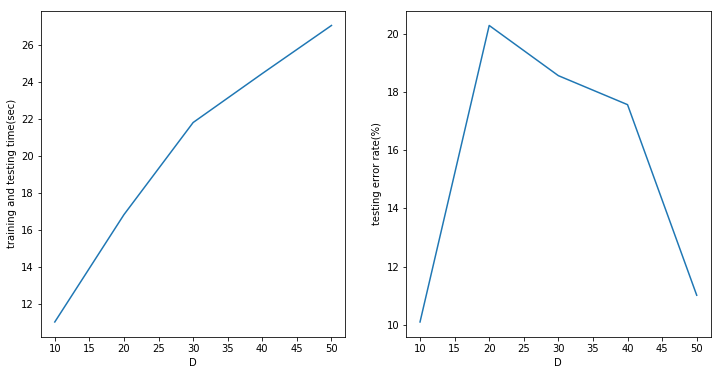

In [19]:
D = [10,20,30,40,50]
plot_error_and_time(D,0.0001,10)

In [20]:
rbf.RandomBinning.evaluate_random_binning(np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test), 10,"classification")

MemoryError: 

In [ ]:
from sklearn.svm import SVC
start_time = time.time()
clf = SVC()
clf.fit(X_train, y_train) 
y_pred = clf.predict(X_test)
print("--- %s seconds ---" % (time.time() - start_time))

error = classification_err(y_test, y_pred)
print("testing error:   %0.3f" % error)